<a href="https://colab.research.google.com/github/yukiao/Pengantar-Deep-Learning/blob/main/Week5/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Silverius Sony Lembang  
NIM  : H071191002

# Configuration

In [41]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from datetime import  datetime
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# Architecture

In [43]:
class Residual(nn.Module):
  def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [44]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [45]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

In [46]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [47]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(512, 10))

# Helpers

In [48]:
# Get accuracy on training
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [49]:
def plot_train(train_losses, train_accuracies):
  train_losses = torch.tensor(train_losses, device='cpu')
  train_accuracies = torch.tensor(train_accuracies, device='cpu')

  train_losses = train_losses.numpy()
  train_accuracies = train_accuracies.numpy()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

  ax[0].plot(train_losses, color="red", label="Training Loss")
  ax[0].set(title="Training Loss over epochs", xlabel="Epoch", ylabel="Loss")
  ax[0].legend()

  ax[1].plot(train_accuracies, color="blue", label="Training Accuracy")
  ax[1].set(title="Training Accuracy over epochs", xlabel="Epoch", ylabel="Accuracy")
  ax[1].legend()

  fig.show()

In [50]:
def train(model, train_loader, criterion, optimizer, device):
  model.train()

  for X, y_true in train_loader:
    optimizer.zero_grad()
    running_loss = 0

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [51]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    print("Start Training")
    print(f"Using {device} device")
    # Train model

    train_losses = []
    train_accuracies = []

    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accuracies.append(train_acc)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Loss: {train_loss:.4f}\t'
                  f'Accuracy: {100 * train_acc:.2f}%\t')
    plot_train(train_losses, train_accuracies)
    print("Finish")
    return model, optimizer

In [52]:
def imshow(img, title, index):
  plt.subplot(1,5,index)
  plt.axis('off')
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0,1)
  plt.title(title)
  plt.imshow(img.reshape((96, 96)), cmap='gray')

# Training

In [53]:
train_dataset = datasets.MNIST("./data",
                                 train=True,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                 ]),
                                 download = True)

test_dataset = datasets.MNIST("./data",
                                 train = False,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1325,), (0.3105,))
                                 ]),
                                 download = True)

In [54]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [55]:
torch.manual_seed(RANDOM_SEED)
model = net.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Start Training
Using cuda device
05:00:35 --- Epoch: 0	Loss: 0.0002	Accuracy: 97.46%	
05:02:54 --- Epoch: 1	Loss: 0.0001	Accuracy: 99.32%	
05:05:12 --- Epoch: 2	Loss: 0.0000	Accuracy: 98.25%	
05:07:31 --- Epoch: 3	Loss: 0.0000	Accuracy: 99.12%	
05:09:49 --- Epoch: 4	Loss: 0.0000	Accuracy: 99.19%	
05:12:08 --- Epoch: 5	Loss: 0.0000	Accuracy: 99.61%	
05:14:26 --- Epoch: 6	Loss: 0.0000	Accuracy: 99.57%	
05:16:45 --- Epoch: 7	Loss: 0.0000	Accuracy: 99.58%	
05:19:03 --- Epoch: 8	Loss: 0.0000	Accuracy: 99.64%	
05:21:22 --- Epoch: 9	Loss: 0.0000	Accuracy: 99.74%	
Finish


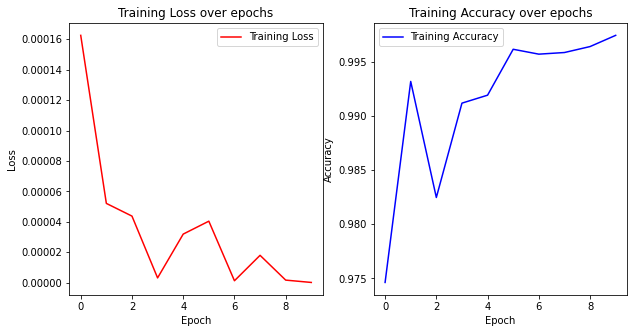

In [56]:
model, optimizer = training_loop(model, criterion, optimizer, train_loader, NUM_EPOCHS, device)

# Testing

In [57]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [58]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {format(100 * correct / total)} %')

Accuracy of the network on the 10000 test images: 99.29 %


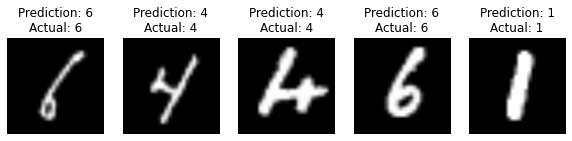

In [59]:
inputs, classes = next(iter(test_loader))
original_inputs = inputs
original_classes = classes

inputs = inputs.to(device)
classes = classes.to(device)

correct = 0

fig = plt.figure(figsize=(10,10))
for i in range(5):
  with torch.no_grad():
    model.eval()
    output = model(inputs[i].reshape(1, 1, 96, 96))
    out = output.cpu().data.numpy().argmax()
    predicted = out.item()
    correct = out == classes[i].item()
    imshow(original_inputs[i], f"Prediction: {predicted}\nActual: {classes[i].item()}", i+1)

plt.show()

In [60]:
# lr, num_epochs, batch_size = 0.05, 10, 256
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())